# Surprise
## Software Presentation / Tutorial
## DSC 672: Data Science Capstone
## Ross Pollock | rmpollo1@gmail.com

### General Libraries 

In [28]:
import numpy as np 
import pandas as pd 
import sqlite3 as sql 
import matplotlib.pyplot as plt 
import seaborn as sns

### Surpise Library 
Installation<br><br>
$pip install scikit-surprise

### Dataset and Reader Classes

In [29]:
# Data Loading
from surprise import Dataset, Reader

### Recommender Algorithms

In [30]:
# Recommender Algorithms
# Simple
# - NormalPredictor
# - BaselineOnly
# Neighborhood Methods
# - KNNBasic
# - KNNWithMeans
# - KNNWithZScore
# - KNNBaseline
# Matrix Factorization Methods
# - SVD
# - SVDpp
# - NFM 
# Others
# - Co-Clustering
# - Slope One
from surprise import NormalPredictor, KNNBasic, SVD 

### Evaluation Metrics

In [31]:
# Metrics
# Available Metrics 
# - Root Mean Squared Error (RMSE)
# - Mean Squared Error (MSE)
# - Mean Absolute Error (MAE)
# - Fraction of Concordant Pairs (FCP)
from surprise.accuracy import rmse, mae

### Model Selection 

In [32]:
# Model Selection 
# Cross Validation
# - KFold
# - RepeatedKFold
# - ShuffleSplit
# - LeaveOneOut
# - PredefinedKFold
# Parameter Search
# - GridSearchCV
# - RandomSearchCV
from surprise.model_selection import GridSearchCV, train_test_split

### Model Reuse

In [33]:
# Saving and Loading
from surprise.dump import dump, load

### Utility Functions

In [34]:
def rating_info(df,uid_col='uid',iid_col='iid',rating_col='rui'):
    '''
    Utility Function 
    Displays some info about rating dataframe

    Parameters
    ----------
    df: pd.Dataframe
        - dataframe of user ratings
    uid_col: str
    iid_col: str
    rating_col: str
        - Columns Name for 
        - user ids, item ids and ratings 
        - respectively 
    '''
    n_users = df[uid_col].nunique()
    n_items = df[iid_col].nunique()
    n_samples = df.shape[0]
    sparsity = 1 - n_samples / (n_users*n_items)
    print(f'Number of Users: {n_users}')
    print(f'Number of Items: {n_items}')
    print(f'Number of Ratings: {n_samples}')
    print(f'Sparsity: {sparsity*100:0.2f}%')

In [35]:
def sample_users(df,user_col,n_users=1_000):
    # Unique Users
    sample_users = ratings_df[user_col].unique()
    # Sample 5k without replacement
    sample_users = np.random.choice(sample_users,n_users,replace=False)
    # Subset Ratings Dataframe
    subset = df[ratings_df[user_col].isin(sample_users)]
    return subset

### Load Ratings from Database

In [36]:
# Path to Climbing Database
db_path = '/Users/ross/Documents/DePaul/Summer20/Project/climbing/data/climbing_full.sqlite'
# Load Ratings 
with sql.connect(db_path) as db_conn:
    ratings_df = pd.read_sql_query(
    '''
    SELECT user_id, route_id, AVG(user_star) AS rating
    FROM ticks 
    WHERE user_star
    BETWEEN 0 AND 4
    GROUP BY user_id, route_id
    '''
    ,db_conn)
# View Some Ratings
ratings_df.head()

,user_id,route_id,rating
0,10101,105847227,4.0
1,10102,105717310,4.0
2,10102,105717328,4.0
3,10102,105717346,2.0
4,10102,105717349,4.0


### Sample some Users
KNN Algorithms Compute Similarity Matrix which can eat up RAM

In [37]:
rating_subset = sample_users(ratings_df,'user_id',1_000)
# View Result
rating_subset.head()

,user_id,route_id,rating
16564,10752,105799721,3.0
16565,10752,106797087,2.0
16566,10752,106798163,2.0
16567,10752,106798174,2.0
20062,10859,105749158,4.0


In [38]:
rating_info(rating_subset,'user_id','route_id','rating')

Number of Users: 1000
Number of Items: 22867
Number of Ratings: 38665
Sparsity: 99.83%


### Loading Data from Pandas Dataframe

In [39]:
# Data Reader with rating information
# Rating Scale: tuple
# - (Default 1-5)
# Line Format: str
# - (Default 'user item rating')
# Sep: char
# - (Default None | space)
rating_reader = Reader(rating_scale=(0,4))
# Dataset Creation 
# From Pandas Dataframe
rating_dataset = Dataset.load_from_df(rating_subset,rating_reader)

# From File
rating_file = '/Users/ross/Documents/DePaul/Summer20/Project/climbing/Formal_Docs/Software_Presentation/datasets/climbing_sample.csv'
rating_file_reader = Reader(line_format='rating user item',rating_scale=(0,4),sep=',')
rating_file_dataset = Dataset.load_from_file(rating_file,rating_file_reader)

### Train Set Split

In [40]:
train_set, test_set = train_test_split(rating_dataset,test_size=0.25)

### Basic Fit and Test Model

In [41]:
recommender = KNNBasic(verbose=False)
recommender.fit(train_set)
test_predictions = recommender.test(test_set)

metrics = {'RMSE':rmse,'MAE':mae}
print('KNN Basic Test Metrics')
for m,f in metrics.items():
    print(f'{m}: {f(test_predictions,verbose=False):0.4f}')

KNN Basic Test Metrics
RMSE: 0.8594
MAE: 0.6753


### KNN Grid Search 

In [42]:
algo = KNNBasic
param_grid = {
    'k':[10,20,40], # Max Number of Neighbors
    'verbose':[False], # Surpress Printouts
    'sim_options':
        {
            'name':['msd','cosine'] # Similarity Measures
        }
}

grid = GridSearchCV(algo,param_grid=param_grid,cv=3)
grid.fit(rating_dataset)

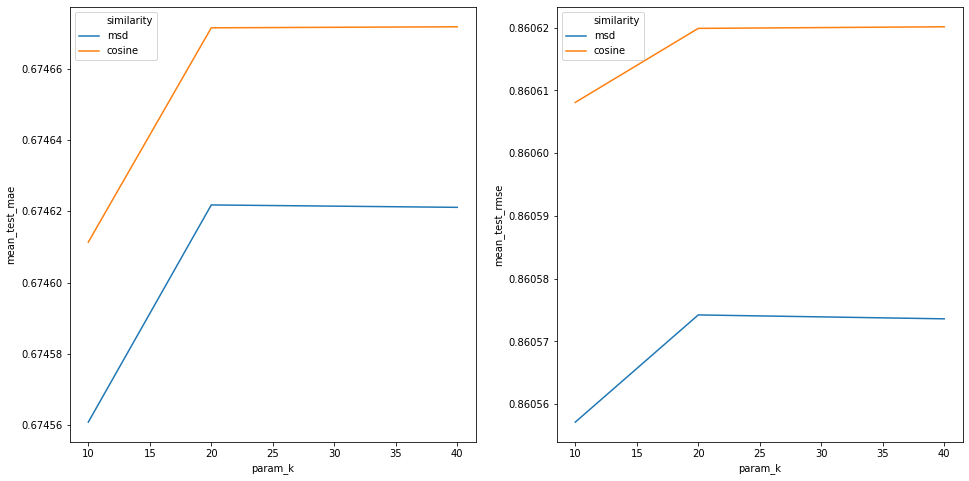

In [43]:
fig, axs = plt.subplots(ncols=2,figsize=(16,8))
knn_results = pd.DataFrame(grid.cv_results)
knn_results['similarity'] = knn_results['param_sim_options'].apply(lambda x: x['name'])
sns.lineplot(x='param_k',y='mean_test_mae',hue='similarity',data=knn_results,ax=axs[0])
sns.lineplot(x='param_k',y='mean_test_rmse',hue='similarity',data=knn_results,ax=axs[1])
plt.show()

### Refit Recommender

In [44]:
recommender = KNNBasic(verbose=False,k=10)
recommender.fit(train_set)

### Get Most Similar Users

In [45]:
# Get Raw User ID
raw_user_id = train_set.to_raw_uid(train_set.all_users()[0])
print(raw_user_id)
# Convert Raw User ID to Inner User ID
user_inner_id = train_set.to_inner_uid(raw_user_id)
# Get Closest Users
inner_neighbors = recommender.get_neighbors(user_inner_id,10)
raw_neighbors = [train_set.to_raw_uid(uid) for uid in inner_neighbors]
print(raw_neighbors)

200137221
[112775824, 108584079, 108696498, 110739544, 110883429, 106649121, 111931271, 111862724, 111856908, 110054827]


### Top-K Items

In [46]:
def top_k(recommender,uid,iids,k=5):
    pred_ratings = np.empty(len(iids))
    for idx, iid in enumerate(iids):
        # Predict Returns tuple( uid, iid, true_rui, est_rui, info)
        _,_,_,est,_ = recommender.predict(uid,iid,clip=False)
        pred_ratings[idx] = est
    top_k_items = np.argsort(pred_ratings)[::-1][:k] 
    return iids[top_k_items],pred_ratings[top_k_items]

In [47]:
item_ids = np.random.choice(rating_subset.route_id.unique(),50,replace=False)
top_items, top_items_ratings = top_k(recommender,raw_user_id,item_ids,10)
for k,(iid, rui) in enumerate(zip(top_items, top_items_ratings),start=1):
    print(f'{k:<3} | Route Id: {iid} | Est. Rating {rui:0.2f}')

1   | Route Id: 106719972 | Est. Rating 4.00
2   | Route Id: 105747633 | Est. Rating 4.00
3   | Route Id: 105867858 | Est. Rating 4.00
4   | Route Id: 111971485 | Est. Rating 4.00
5   | Route Id: 105934922 | Est. Rating 4.00
6   | Route Id: 105973398 | Est. Rating 4.00
7   | Route Id: 105753391 | Est. Rating 3.00
8   | Route Id: 105751345 | Est. Rating 3.00
9   | Route Id: 108505709 | Est. Rating 3.00
10  | Route Id: 106175795 | Est. Rating 3.00


### Matrix Factorization

In [48]:
mf_train_set, mf_test_set = train_test_split(rating_file_dataset,test_size=0.25)

In [49]:
mf_recommender = SVD()
mf_recommender.fit(mf_train_set)

metrics = {'RMSE':rmse,'MAE':mae}
print('SVD Test Metrics')
for m,f in metrics.items():
    print(f'{m}: {f(test_predictions,verbose=False):0.4f}')

SVD Test Metrics
RMSE: 0.8594
MAE: 0.6753


In [50]:
param_grid = {
    'n_factors':[10,20,50,100], # Latent Factors 
    'verbose':[False], # Surpress Printouts
}

grid = GridSearchCV(SVD,param_grid=param_grid,cv=3)
grid.fit(rating_file_dataset)

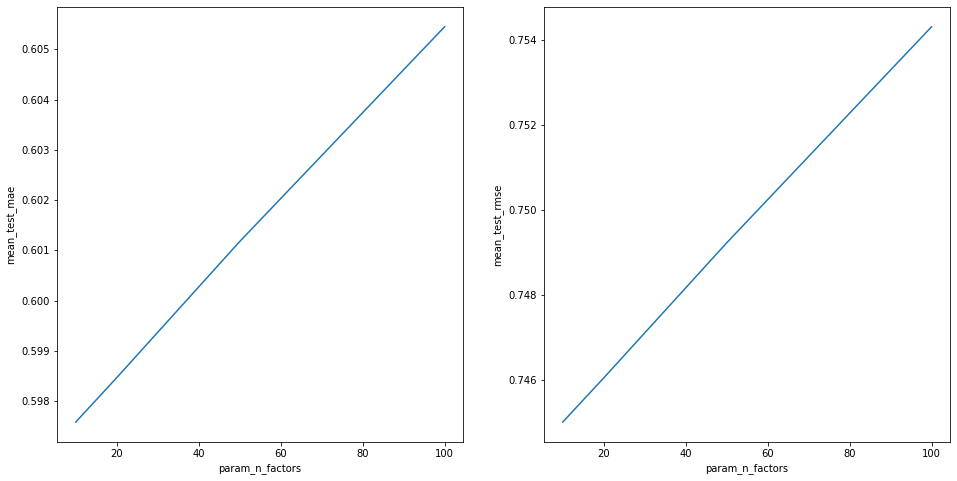

In [51]:
fig, axs = plt.subplots(ncols=2,figsize=(16,8))
svd_results = pd.DataFrame(grid.cv_results)
sns.lineplot(x='param_n_factors',y='mean_test_mae',data=svd_results,ax=axs[0])
sns.lineplot(x='param_n_factors',y='mean_test_rmse',data=svd_results,ax=axs[1])
plt.show()

In [52]:
mf_recommender = SVD(n_factors=10)
mf_recommender.fit(rating_file_dataset.build_full_trainset())

### Saving and Loading Models

In [53]:
model_dir = '/Users/ross/Documents/DePaul/Summer20/Project/climbing/Formal_Docs/Software_Presentation/recommenders/'

model_file = 'svd.pickle'

# Save Recommender as .pickle 
dump(model_dir + model_file,algo=mf_recommender)

In [54]:
predictions, model = load(model_dir+model_file)

In [58]:
with open('/Users/ross/Documents/DePaul/Summer20/Project/climbing/Formal_Docs/Software_Presentation/datasets/climbing_sample.csv') as f: 
    for _ in range(10):
        line = f.readline()
        rating, user_id, item_id = line.strip().split(',') 
        uid, iid, rui, est, _ = model.predict(user_id,item_id,rating,clip=False)
        print(est)

3.373012542874535
3.1602530400802507
2.499018563125635
2.800331497132613
3.454342088549931
2.3356629840624885
2.7035581999291236
2.384533717813569
2.833485073677298
2.2702658891648237


## Notes
- User / Item Encoding located in trainset class
- If user / item not in system returns global average